### Small adjustment

In [16]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("https://static.bc-edx.com/data/dla-1-2/m21/lms/starter/charity_data.csv")

# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=['EIN', 'NAME'])

# Choose a cutoff value of 500 and create a list of application types to be replaced
all_app_types = application_df['APPLICATION_TYPE'].value_counts().to_dict()
application_types_to_replace = [i for i in all_app_types.keys() if all_app_types[i] < 500]

# Replace in dataframe
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")

# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`
all_class_types = application_df['CLASSIFICATION'].value_counts().to_dict()
classifications_to_replace = [i for i in all_class_types.keys() if all_class_types[i] < 1000]

# Replace in dataframe
for cls in classifications_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")

# Get all categorical data columns into a list
dummies_cols = []

cols = application_df.columns
typs = application_df.dtypes.values

for c in range(len(cols)):
    if (typs[c] == 'object'):
        dummies_cols.append(cols[c])

# Convert categorical data to numeric with `pd.get_dummies`
dummies_df = pd.get_dummies(application_df[dummies_cols])

# Concatenate the DF with the dummy data with the original dataset
concat_df = pd.concat([application_df, dummies_df], axis=1)

# Drop the unused columns
concat_df = concat_df.drop(columns=dummies_cols)

# Split our preprocessed data into our features and target arrays
y = concat_df['IS_SUCCESSFUL']
X = concat_df.drop(columns='IS_SUCCESSFUL')

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

def train_and_evaluate_model(data_train, data_test, in_features, in_units, internal_layers, internal_activation, n_epochs):

    # Check the validity of the parameters
    if len(internal_layers) == len(internal_activation):

        n_hidden = len(internal_layers)
    
        nn = tf.keras.models.Sequential()

        # First hidden layer
        nn.add(tf.keras.layers.Dense(units=in_units, activation="relu", input_dim=in_features))

        # Add hidden layers
        for i in range(n_hidden):
            nn.add(tf.keras.layers.Dense(units=internal_layers[i], activation=internal_activation[i]))

        # Output layer
        nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

        # Compile the model
        nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

        # Train the model
        nn.fit(data_train['X'], data_train['y'], epochs=n_epochs,verbose=0)

        # Evaluate the model using the test data
        model_loss, model_accuracy = nn.evaluate(data_test['X'],data_test['y'],verbose=2)

        return model_loss, model_accuracy, nn
    
    else:
        print('Error: internal_layers and internal_activation must be the same length')
        print(f"internal_layers has length {len(internal_layers)}.")
        print(f"internal_activation has length {len(internal_activation)}.")
        return -1

In [7]:
print(f"Number of features: {len(X.columns)}")

Number of features: 43


# Determining the number of layers and neurons
We use the following reference: https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3

This gives the following guidelines (some may be mutually exclusive):
- We should use 1 or 2 hidden layers to cover most cases
- The number of hidden neurons should be between the size of the input layer and the size of the output layer
- The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer
- The number of hidden neurons should be less than twice the size of the input layer
- Most of the problems can be solved by using a single hidden layer with the number of neurons equal to the mean of the input and output layer. 

Based on this, we estabblish the following:
- The input layer has 43 neurons (the number of features)
- Number of hidden neurons (N): 1 < N < 43
- N < 1 + 43 * 2/3 => N < 29
- N < 2*43 => N < 86
- N = (43 + 1)/2 = 22, within one layer

In [19]:
in_features = len(X.columns)
in_units = 43
internal_layers = [22, 7]
internal_activation = ['selu', 'selu']

data_train = {'X': X_train_scaled, 'y': y_train}
data_test = {'X': X_test_scaled, 'y': y_test}

n_epochs = 20

model_loss, model_accuracy, model = train_and_evaluate_model(data_train, data_test, in_features, in_units, internal_layers, internal_activation, n_epochs)

print(f"Loss: {100*model_loss:.2f}%")
print(f"Accuracy: {100*model_accuracy:.2f}%")

268/268 - 0s - loss: 0.5529 - accuracy: 0.7263 - 278ms/epoch - 1ms/step
Loss: 55.29%
Accuracy: 72.63%


In [24]:
in_features = len(X.columns)
in_units = 22
internal_layers = [7]
internal_activation = ['selu']

data_train = {'X': X_train_scaled, 'y': y_train}
data_test = {'X': X_test_scaled, 'y': y_test}

n_epochs = 25

model_loss, model_accuracy, model = train_and_evaluate_model(data_train, data_test, in_features, in_units, internal_layers, internal_activation, n_epochs)

print(f"Loss: {100*model_loss:.2f}%")
print(f"Accuracy: {100*model_accuracy:.2f}%")

268/268 - 0s - loss: 0.5531 - accuracy: 0.7255 - 273ms/epoch - 1ms/step
Loss: 55.31%
Accuracy: 72.55%


## Keras tuner

In [26]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):

    input_dim = 43


    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','selu','sigmoid','tanh'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=2,
        max_value=30,
        step=2), activation=activation, input_dim=input_dim))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 2)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=2,
            max_value=10,
            step=2),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

In [27]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 60 Complete [00h 00m 22s]
val_accuracy: 0.7252478003501892

Best val_accuracy So Far: 0.7286297082901001
Total elapsed time: 00h 09m 15s


In [28]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)

print(f"Loss: {100*model_loss:.2f}%")
print(f"Accuracy: {100*model_accuracy:.2f}%")

268/268 - 0s - loss: 0.5523 - accuracy: 0.7286 - 336ms/epoch - 1ms/step
Loss: 55.23%
Accuracy: 72.86%


In [29]:
# Export the model to HDF5 file
filename = 'AlphabetSoupCharity_Optimisation.h5'
pickle.dump(best_model, open(filename, 'wb'))

# Open pickled model

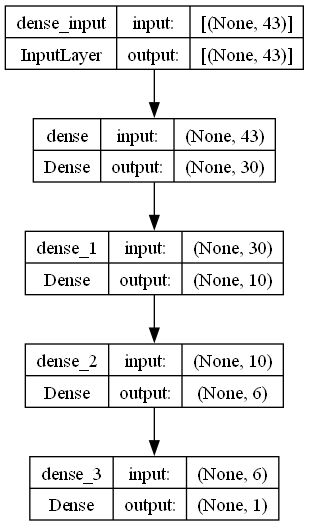

In [30]:
loaded_best_model = pickle.load(open('AlphabetSoupCharity_Optimisation.h5', 'rb'))
dot_img_file = 'img/model_4.png'
tf.keras.utils.plot_model(loaded_best_model, to_file=dot_img_file, show_shapes=True)